In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]
    df['topic_{}_2'.format(i)] = df['topic_{}'.format(i)]**2

In [8]:
all_topics = []
reg_topics = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    all_topics.append('topic_{}_2'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))
        reg_topics.append("topic_{}_2".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*7
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

### Regression on Average Comments

In [13]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           2.32e-34
Time:                        16:06:38   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [14]:
y, X = dmatrices('avg_comments ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .05)
y, X = dmatrices('avg_comments ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     9.776
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           3.30e-41
Time:                        16:06:56   Log-Likelihood:                -685.68
No. Observations:                 562   AIC:                             1451.
Df Residuals:                     522   BIC:                             1625.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-2.0, 2.0)

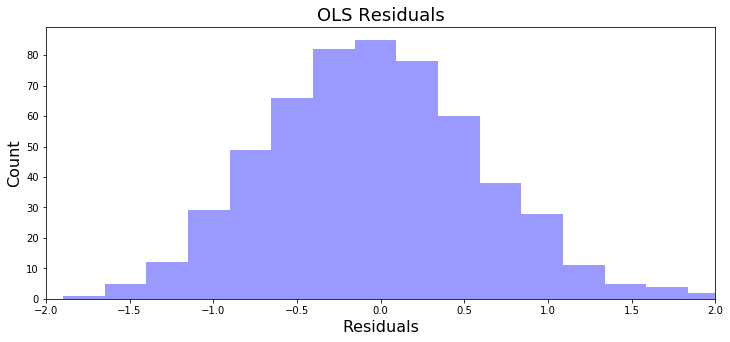

In [15]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

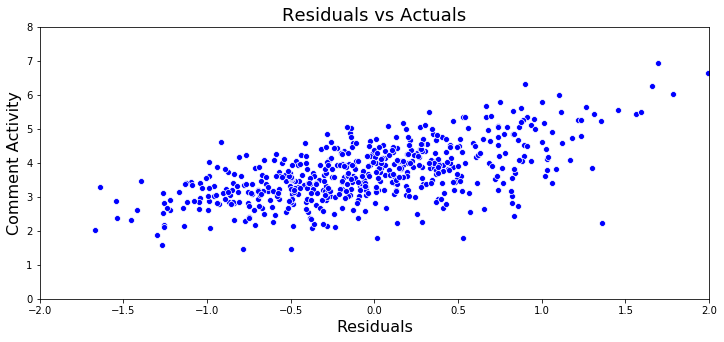

In [16]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [17]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())

2019-12-07 16:06:57,385 [1742] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5024091203156327
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      522
Model Family:                   Gamma   Df Model:                           39
Link Function:                    log   Scale:                        0.039572
Method:                          IRLS   Log-Likelihood:                -575.73
Date:                Sat, 07 Dec 2019   Deviance:                       18.892
Time:                        16:06:57   Pearson chi2:                     20.7
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

In [18]:
all_data['comment_prediction'] = res.predict(X)

(0, 1.5)

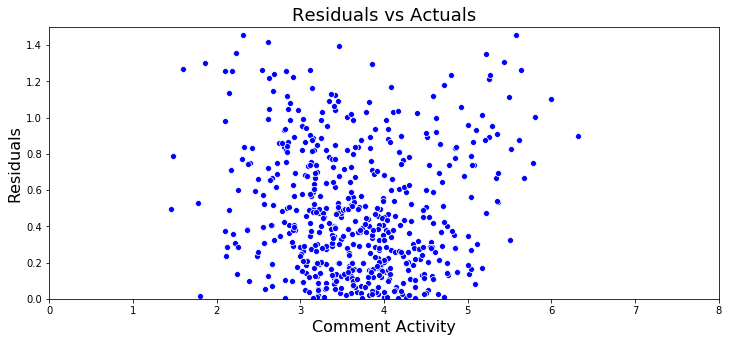

In [19]:
plt.figure(figsize=(12, 5))
sns.scatterplot(y=abs(yhat - all_data['avg_comments']), x=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.ylabel('Residuals', fontsize=16)
plt.xlabel('Comment Activity', fontsize=16)
plt.xlim([0, 8])
plt.ylim([0, 1.5])

In [20]:
crowd_pct_variation = utils.build_crowd_pct_variation(all_data, X)
predictions = res.predict(crowd_pct_variation)

In [21]:
len(predictions)

100

Text(0.5, 0, 'Crowd Source Percentage')

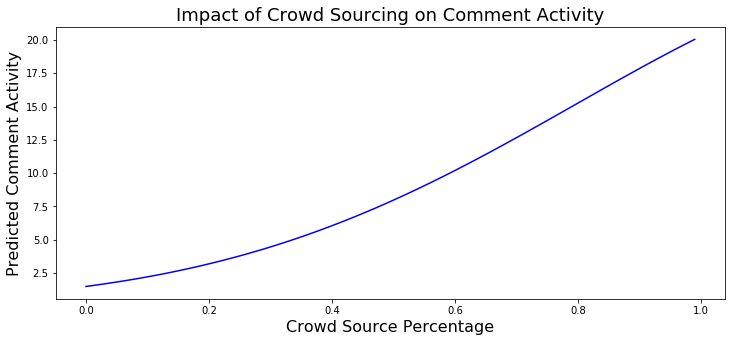

In [22]:
plt.figure(figsize=(12, 5))
sns.lineplot(y=predictions, x=[i/100 for i in range(100)], color='blue')
plt.title('Impact of Crowd Sourcing on Comment Activity', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

In [23]:
all_data[['avg_clustering', 'avg_min_path', 'gini_coefficient']].describe()

,avg_clustering,avg_min_path,gini_coefficient
count,562.000000,562.000000,562.000000
mean,0.601003,2.187393,0.561907
std,0.140855,0.232263,0.048177
min,0.000000,1.400000,0.285714
25%,0.522477,2.012390,0.535522
50%,0.627541,2.145767,0.568641
75%,0.704530,2.331743,0.592101
max,0.878524,3.054147,0.696200


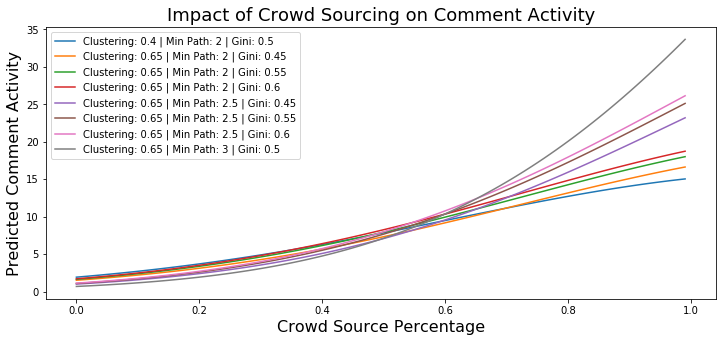

In [24]:
plt.figure(figsize=(12, 5))
plt.title('Impact of Crowd Sourcing on Comment Activity', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

data_copy = all_data.copy(deep=True)
combos = [(0.4, 2, .5),
          (0.65, 2, .45),
          (0.65, 2, .55),
          (0.65, 2, .6),
          (0.65, 2.5, .45),
          (0.65, 2.5, .55),
          (0.65, 2.5, .6),
          (0.65, 3, .5)]
for combo in combos:
    avg_clustering, avg_min_path, gini_coefficient = combo
    data_copy['avg_clustering'] = avg_clustering
    data_copy['avg_min_path'] = avg_min_path
    data_copy['gini_coefficient'] = gini_coefficient
    label = 'Clustering: {} | Min Path: {} | Gini: {}'.format(avg_clustering,
                                                              avg_min_path,
                                                              gini_coefficient)
    crowd_pct_variation = utils.build_crowd_pct_variation(data_copy, X)
    predictions = res.predict(crowd_pct_variation)
    sns.lineplot(y=predictions, x=[i/100 for i in range(100)], label=label)

### Regression on Mean Requirement Duration

In [25]:
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues ',
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     22.62
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           2.75e-38
Time:                        16:07:01   Log-Likelihood:                -3524.3
No. Observations:                 562   AIC:                             7073.
Df Residuals:                     550   BIC:                             7125.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [26]:
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .10)
y, X = dmatrices('duration_mean ~ crowd_pct + avg_clusteringXcrowd_pct - avg_clustering ' + features ,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          duration_mean   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     7.750
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           2.21e-48
Time:                        16:07:29   Log-Likelihood:                -3401.2
No. Observations:                 562   AIC:                             6960.
Df Residuals:                     483   BIC:                             7303.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-250, 250)

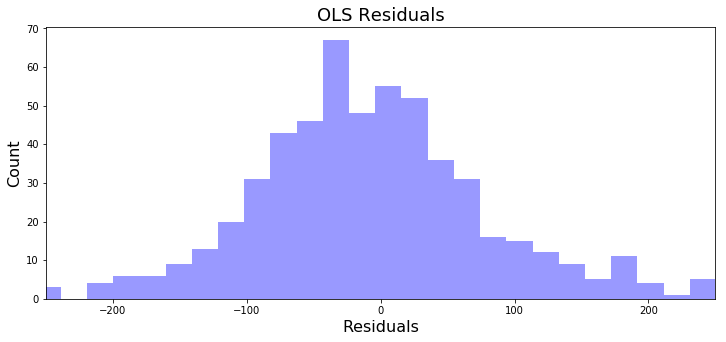

In [27]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-250, 250])

(-200, 200)

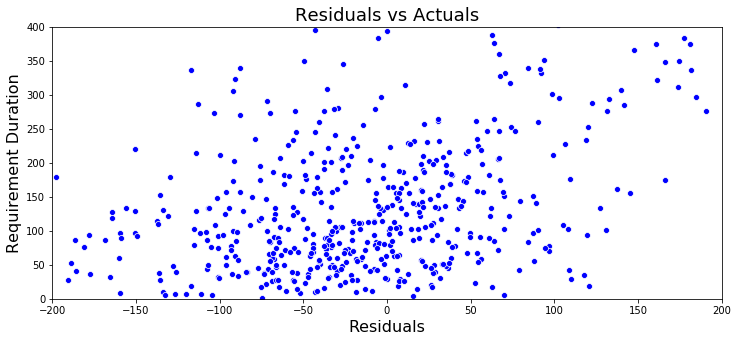

In [28]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration', fontsize=16)
plt.ylim([0, 400])
plt.xlim([-200, 200])

In [29]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())
yhat = res.predict(X)

2019-12-07 16:07:30,536 [1742] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5089857510573146
                 Generalized Linear Model Regression Results                  
Dep. Variable:          duration_mean   No. Observations:                  562
Model:                            GLM   Df Residuals:                      483
Model Family:                   Gamma   Df Model:                           78
Link Function:                    log   Scale:                         0.40318
Method:                          IRLS   Log-Likelihood:                -3195.2
Date:                Sat, 07 Dec 2019   Deviance:                       220.33
Time:                        16:07:30   Pearson chi2:                     195.
No. Iterations:                    32                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

In [30]:
all_data['duration_prediction'] = res.predict(X)

(0, 200)

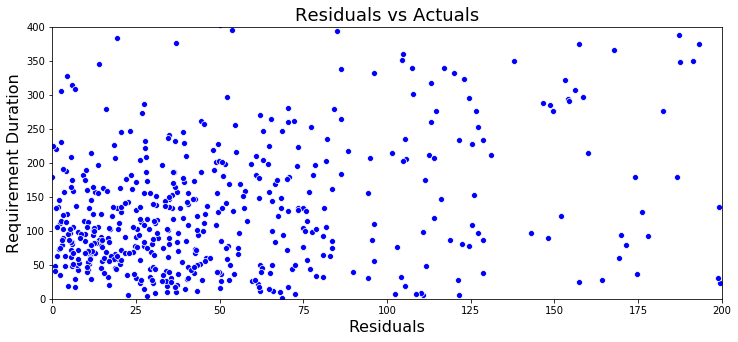

In [31]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['duration_mean']), y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration', fontsize=16)
plt.ylim([0, 400])
plt.xlim([0, 200])

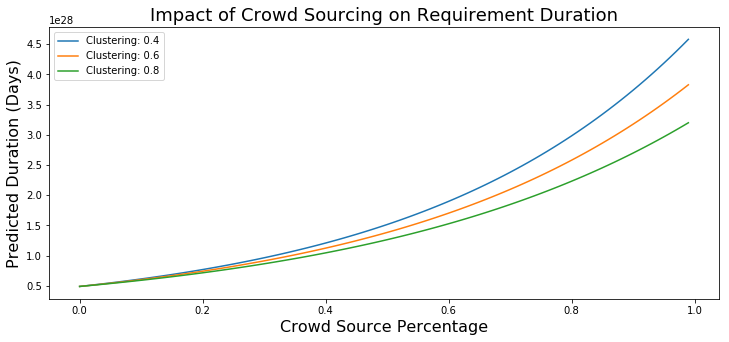

In [32]:
plt.figure(figsize=(12, 5))
plt.title('Impact of Crowd Sourcing on Requirement Duration', fontsize=18)
plt.ylabel('Predicted Duration (Days)', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

data_copy = all_data.copy(deep=True)
for avg_clustering in [0.4, 0.6, 0.8]:
    data_copy['avg_clustering'] = avg_clustering
    label = 'Clustering: {}'.format(avg_clustering)
    crowd_pct_variation = utils.build_crowd_pct_variation(data_copy, X)
    predictions = res.predict(crowd_pct_variation)
    sns.lineplot(y=predictions, x=[i/100 for i in range(100)], label=label)

### Post-Hoc Analysis

In [33]:
data_copy = all_data.copy(deep=True)
data_copy['prediction'] = res.predict(X)
result_data = data_copy[['package', 'organization', 'crowd_pct', 'total_contributors', 'issues_over_time', 
                         'comment_prediction', 'avg_comments', 'duration_prediction', 'duration_mean',
                         'avg_clustering', 'avg_min_path', 'gini_coefficient']]

result_data.describe()

,crowd_pct,total_contributors,issues_over_time,comment_prediction,avg_comments,duration_prediction,duration_mean,avg_clustering,avg_min_path,gini_coefficient
count,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,0.480865,11.539146,0.530581,3.762720,3.766143,168.585443,164.077369,0.601003,2.187393,0.561907
std,0.263940,10.587185,0.694513,0.663341,1.079171,152.832823,154.414544,0.140855,0.232263,0.048177
min,0.006711,1.000000,0.071356,1.679010,1.457227,23.563568,1.107843,0.000000,1.400000,0.285714
25%,0.265306,5.000000,0.171590,3.357462,3.148360,86.033827,63.040033,0.522477,2.012390,0.535522
50%,0.500000,9.000000,0.291997,3.750987,3.629720,127.171083,116.893229,0.627541,2.145767,0.568641
75%,0.699603,15.000000,0.608008,4.166635,4.223124,202.148946,209.648094,0.704530,2.331743,0.592101
max,0.985294,86.000000,7.239209,6.545313,15.493750,2125.620592,1309.115385,0.878524,3.054147,0.696200


#### The One Man Show

The projects have one primary contributor. As a result, they have very little comment activity on a typical issue. In addition, it takes them a very long time to close an issue out. Although they are taking input from the crowd, the head honcho effectively decides the direction of the project. Notice, the average min path for these projects is always right around 2, and it has a tight interquartile range for that metric. There is variation in the gini coefficient. However, that is largely driven by the number of people in the network.

In [34]:
one_man_show = result_data[(result_data['crowd_pct'] > .5) 
                           & (result_data['avg_clustering'] < .5)]

In [35]:
one_man_show.describe()

,crowd_pct,total_contributors,issues_over_time,comment_prediction,avg_comments,duration_prediction,duration_mean,avg_clustering,avg_min_path,gini_coefficient
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.690042,7.238095,0.383862,3.863832,4.030386,120.232188,113.051905,0.395551,2.018945,0.568874
std,0.116756,4.332574,0.376499,0.523031,1.072884,68.097838,92.404748,0.087268,0.081607,0.038334
min,0.513699,2.000000,0.095476,2.310554,2.102740,32.328942,9.775862,0.125494,1.905797,0.496795
25%,0.600000,4.000000,0.172061,3.620900,3.203387,70.026075,43.529635,0.371301,1.980995,0.543465
50%,0.689344,6.000000,0.261408,3.840540,3.842149,105.327402,79.970580,0.426162,1.992060,0.567068
75%,0.756366,9.000000,0.409377,4.180922,4.484320,150.267524,154.178579,0.449605,2.042209,0.585260
max,0.974359,19.000000,2.063745,4.909549,6.558685,339.503222,376.617978,0.496294,2.376334,0.696200


In [36]:
one_man_show.sort_values('avg_clustering', ascending=False)

,package,organization,crowd_pct,total_contributors,issues_over_time,comment_prediction,avg_comments,duration_prediction,duration_mean,avg_clustering,avg_min_path,gini_coefficient
111,sh,amoffat,0.600000,8,0.097663,3.884450,3.876607,228.071174,230.689655,0.496294,2.064050,0.555051
499,jQuery-contextMenu,swisnl,0.832432,16,0.454865,3.478037,3.127042,339.503222,376.617978,0.495103,2.376334,0.572044
384,redisson,mrniko,0.707207,6,2.063745,4.629938,3.627385,68.354469,35.342995,0.487462,2.180124,0.604109
174,libjson-rpc-cpp,cinemast,0.692308,4,0.107905,4.232249,3.721774,190.375151,133.125000,0.486912,1.983471,0.585978
127,jsblocks,astoilkov,0.571429,3,0.203079,4.091527,3.923664,89.489815,67.605263,0.482736,2.054299,0.539201
306,mediaelement,johndyer,0.794118,5,0.324472,4.360660,5.636971,60.449673,52.470588,0.461761,2.171662,0.589849
159,javacv,bytedeco,0.833333,19,1.068493,4.846462,5.802073,94.651377,84.914773,0.457756,2.003489,0.630359
481,jsduck,senchalabs,0.658537,3,0.095476,3.872711,2.841346,252.387615,201.631579,0.454245,2.027985,0.586180
222,elasticsearch-dsl-py,elastic,0.742857,3,0.157455,4.179672,2.914163,57.913926,35.428571,0.453174,2.090525,0.576618
335,libjpeg-turbo,libjpeg-turbo,0.605405,19,0.812932,3.963747,5.260736,151.126122,55.148148,0.450089,1.994647,0.569643


#### Heavily Used Open Source Tools

These are open source tools that are developed by team, often from corporations. Rather than having a single center of gravity, these projects have multiple centers of gravity. The centers of gravity are typically a small number of core developers, who need to handle a large number of requests from users. The projects in this category tend to source more requirements from the crowd relative to the one man show.

In [37]:
high_adoption = result_data[(result_data['crowd_pct'] > .5) 
            & (result_data['avg_clustering'] < .6)
            & (result_data['avg_min_path'] >= 2.1)].sort_values('avg_min_path', ascending=False)

In [38]:
len(high_adoption)

45

In [39]:
high_adoption.describe()

,crowd_pct,total_contributors,issues_over_time,comment_prediction,avg_comments,duration_prediction,duration_mean,avg_clustering,avg_min_path,gini_coefficient
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.736633,8.977778,0.415110,3.595073,3.363908,143.821102,135.979264,0.551172,2.334670,0.571874
std,0.127379,6.464901,0.426476,0.490445,0.715587,75.365006,99.383691,0.037155,0.210230,0.040958
min,0.513699,1.000000,0.084337,2.361381,2.013953,46.915893,5.457143,0.440510,2.106022,0.397186
25%,0.644231,4.000000,0.170019,3.310724,2.915452,90.853338,52.470588,0.529928,2.175559,0.556764
50%,0.717391,7.000000,0.256975,3.567583,3.222539,127.287966,111.200000,0.560070,2.262356,0.582929
75%,0.832432,13.000000,0.500490,3.892369,3.655689,175.699119,174.400000,0.577185,2.386454,0.596541
max,0.972222,32.000000,2.063745,4.853192,5.636971,351.095774,468.720930,0.599139,2.862075,0.646811


In [40]:
high_adoption.sort_values('avg_clustering', ascending=False)[::5]

,package,organization,crowd_pct,total_contributors,issues_over_time,comment_prediction,avg_comments,duration_prediction,duration_mean,avg_clustering,avg_min_path,gini_coefficient
148,keyboard,boppreh,0.877551,3,0.652091,3.517034,4.588785,100.863147,86.812500,0.599139,2.106022,0.568274
40,Leaflet,Leaflet,0.828571,3,0.293062,3.567583,2.923387,49.710397,77.052632,0.590019,2.509142,0.607842
106,fastjson,alibaba,0.967213,4,1.047853,2.825406,2.572433,61.742760,50.679487,0.579622,2.665469,0.573775
405,orika,orika-mapper,0.909091,3,0.134380,2.857126,2.822485,178.626012,228.100000,0.568580,2.411740,0.525422
45,CNTK,Microsoft,0.894737,4,0.406107,3.196848,3.342448,74.784839,40.700000,0.564489,2.862075,0.555113
132,aws-sdk-php,aws,0.717391,4,0.213811,3.358411,3.373118,116.088770,5.457143,0.554624,2.760937,0.613427
356,device-detector,matomo-org,0.555556,13,0.172131,3.513411,2.717063,127.113750,163.850000,0.548328,2.137090,0.589613
333,libharu,libharu,0.900000,1,0.120759,2.361381,2.238095,178.163651,163.000000,0.515973,2.842365,0.397186
122,arangodb-java-driver,arangodb,0.813333,7,0.295941,3.266192,3.206422,94.940837,50.655738,0.502479,2.371919,0.520409
